In [1]:
import copy
import csv
import random

import matplotlib.pyplot as plt
import numpy as np

import ambulance_game as abg

from utility_functions import *

## Hospital 1
- Rates
  - Ambulance arrival rate: $\lambda_2 = 1$
  - Other arrival rate: $\lambda_1 = 0.5$ 
  - Service rate: $\mu = 0.5$
- Resources:
  - Num of servers: $C = 4$
  - Threshold: $T = 7$
  - System capacity: $N = 10$
  - Buffer capacity: $M = 7$ 


In [3]:
lambda_2 = 1
lambda_1 = 0.5
mu = 0.7

num_of_servers = 4
threshold = 7
system_capacity = 10
buffer_capacity = 7

## Team priority

Prioritise the experienced staff first
- [Experienced, Mid-level, Mid-level, Intern]

In [4]:
rates = {}
for server_id in range(1, num_of_servers + 1):
    rates[server_id] = {}
    for u in range(buffer_capacity + 1):
        for v in range(system_capacity + 1):
            rates[server_id][(u, v)] = mu

In [45]:
def team_expertise_priority(srv, ind):
    if srv.id_number == 1:
        return 0
    if srv.id_number == 4:
        return 1
    return np.random.random()

Q = abg.simulation.simulate_model(
    lambda_1=lambda_1, 
    lambda_2=lambda_2, 
    mu=rates, 
    num_of_servers=num_of_servers, 
    threshold=threshold, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity,
    runtime=1000,
    num_of_trials=1,
    seed_num=0,
    server_priority_function=team_expertise_priority,
)
if type(Q) is not list:
    Q = [Q]

In [46]:
print("Max inds in parking:", max(Q[0].statetracker.state_probabilities(), key=lambda x: x[0])[0])
print("Max inds in hospital:", max(Q[0].statetracker.state_probabilities(), key=lambda x: x[1])[1])

Max inds in parking: 7
Max inds in hospital: 9


## Utility functions
Weighted averages of some pairs of the following:
- individuals served
- idle time
- service time/rate
$$
    U_k^1 = e (\text{\# served}) + (1-e) (\text{idle time})
$$
$$
    U_k^2 = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) \frac{\text{current time - busy time}}{\text{current time}}
$$
$$
    U_k^3 = e (\text{mean service time})_k + (1 - e) (\text{idle proportion})_k
$$
$$
    U_k^4 = e (\frac{1}{\text{mean service time}_k}) + (1 - e) (\text{idle proportion})_k
$$
$$
    U_k^5 = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) (\text{mean service time})_k
$$
$$
    U_k^6 = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) (\frac{1}{\text{mean service time}_k})
$$

In [47]:
print("SERVER ID \tUTIL.3 \tUTIL.4 \tSERVED \t% BUSY \tMEAN SERVICE")
for srv in Q[0].nodes[2].servers:
    print(
        f"Server {srv.id_number}:" +
        f"\t{round(utility_function_3(Q, srv.id_number, 0.2), 3)}" + 
        f"\t{round(utility_function_4(Q, srv.id_number, 0.2), 3)}" + 
        f"\t{len(srv.served_inds)}" +
        f"\t{round(100 * srv.busy_time / Q[0].current_time, 3)}" +
        f"\t{round(np.mean(srv.service_times), 6)}"
    )

SERVER ID 	UTIL.3 	UTIL.4 	SERVED 	% BUSY 	MEAN SERVICE
Server 1:	0.512	0.373	508	71.146	1.404192
Server 2:	0.651	0.505	382	54.349	1.429814
Server 3:	0.663	0.519	370	52.699	1.425041
Server 4:	0.823	0.672	230	33.235	1.44573


# Reinforcement learning

In [430]:
def pick_a_state(Q):
    """
    Pick a state to update.
    """
    all_states = Q.statetracker.state_probabilities()
    all_visited_states = [state for state in all_states if all_states[state] > 0]
    index_choice = np.random.randint(len(all_visited_states))
    state = all_visited_states[index_choice]
    # print("Chosen state: ", state)
    return state

In [431]:
def pick_policy(Qs, rates, num_of_servers):
    """
    Pick a new policy for a single server.
    """
    new_rates = copy.deepcopy(rates)
    Q = np.random.choice(Qs)
    srv = np.random.randint(1, num_of_servers + 1)
    # print("Chosen server: ", srv)
    state = pick_a_state(Q)
    scale = np.random.uniform(0.5, 1.5)
    new_rates[srv][state] *= scale
    return new_rates, srv

In [432]:
def accept_policy(Qs, utility_function, e_parameter, server_utilities, current_server_id):
    """
    Accept or reject a policy.
    """
    # print(f"Old - new utilities server {current_server_id}: {server_utilities[current_server_id - 1]} - {utility_function(Qs, current_server_id, 0.1)}")
    condition = server_utilities[current_server_id - 1] <= utility_function(
        Qs, current_server_id, e_parameter
    )
    # print("Accept? ", condition)
    return condition


def are_within_limits(rates):
    """
    Check if the rates are within the limits.
    """
    for srv in rates:
        for state in rates[srv]:
            rate = rates[srv][state]
            if rate < 0.1 or rate > 1.3:
                print(f"Rate {rate} out of bounds: Server {srv}, State {state}")
                return False
    # print("All rates within limits.")
    return True

In [433]:
def update_server_utilities(Qs, utility_function, e_parameter, num_of_servers):
    """
    Update the utilities of all servers.
    """
    new_utilities = [
        utility_function(Qs, srv_id, e_parameter) for srv_id in range(1, num_of_servers + 1)
    ]
    return new_utilities

In [446]:
def run_simulation(parameters, rates):
    Qs = abg.simulation.simulate_model(
        lambda_1=parameters["lambda_1"],
        lambda_2=parameters["lambda_2"],
        mu=rates,
        num_of_servers=parameters["num_of_servers"],
        threshold=parameters["threshold"],
        system_capacity=parameters["system_capacity"],
        buffer_capacity=parameters["buffer_capacity"],
        runtime=parameters["runtime"],
        num_of_trials=parameters["num_of_trials"],
        seed_num=parameters["seed_num"],
        server_priority_function=parameters["server_priority_function"],
    )
    if type(Qs) is not list:
        Qs = [Qs]
    return Qs

In [447]:
lambda_2 = 1
lambda_1 = 0.5
mu = 0.7

num_of_servers = 4
threshold = 7
system_capacity = 10
buffer_capacity = 7

In [448]:
rates = {}
for server_id in range(1, num_of_servers + 1):
    rates[server_id] = {}
    for u in range(buffer_capacity + 1):
        for v in range(system_capacity + 1):
            rates[server_id][(u, v)] = mu

In [449]:
def team_expertise_priority(srv, ind):
    if srv.id_number == 1:
        return 0
    if srv.id_number == 4:
        return 1
    return np.random.random()

In [452]:
parameters = {
    "lambda_1": lambda_1,
    "lambda_2": lambda_2,
    "num_of_servers": num_of_servers,
    "threshold": threshold,
    "system_capacity": system_capacity,
    "buffer_capacity": buffer_capacity,
    "runtime": 1000,
    "num_of_trials": 5,
    "seed_num": 0,
    "server_priority_function": team_expertise_priority,
}

In [453]:
initial_rates = copy.deepcopy(rates)
server_utilities = [-float("inf") for srv in range(1, parameters["num_of_servers"] + 1)]
num_of_iterations = 10000
current_utility_function = utility_function_3
e_parameter = 0
all_utilities, all_rates = [], []

In [455]:
Qs = run_simulation(parameters, initial_rates)
for _ in range(num_of_iterations):
    new_rates, server_id = pick_policy(Qs, rates, num_of_servers)
    Qs = run_simulation(parameters, new_rates)
    # print("Within limits:", are_within_limits(new_rates))
    if are_within_limits(new_rates) and accept_policy(
        Qs=Qs, 
        utility_function=current_utility_function, 
        e_parameter=e_parameter,
        server_utilities=server_utilities, 
        current_server_id=server_id
    ):
        server_utilities = update_server_utilities(
            Qs=Qs, 
            utility_function=current_utility_function, 
            e_parameter=e_parameter,
            num_of_servers=parameters["num_of_servers"]
        )
        rates = copy.deepcopy(new_rates)
    
    all_utilities.append(server_utilities.copy())
    all_rates.append(copy.deepcopy(rates))
    # output_to_file(str(server_utilities), "utilities_attempt_5.csv")
    # output_to_file(str(rates), "rates_attempt_5.csv")

    if _ % int(num_of_iterations / 10) == 0:
        print("Iteration:", _)

## Hospital parameters
- Rates
  - Ambulance arrival rate: $\lambda_2 = 1$
  - Other arrival rate: $\lambda_1 = 0.5$ 
  - Service rate: $\mu = 0.7$
- Resources:
  - Num of servers: $C = 4$
  - Threshold: $T = 7$
  - System capacity: $N = 10$
  - Buffer capacity: $M = 7$ 


## Team priority

Prioritise the experienced staff first
- [Experienced, Mid-level, Mid-level, Intern]

## Utility functions
Weighted averages of some pairs of the following:
- individuals served
- idle time
- service time/rate
$$
    U_k^1 = e (\text{\# served}) + (1-e) (\text{idle time})
$$
$$
    U_k^2 = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) \frac{\text{current time - busy time}}{\text{current time}}
$$
$$
    U_k^3 = e (\text{mean service time})_k + (1 - e) (\text{idle proportion})_k
$$
$$
    U_k^4 = e (\frac{1}{\text{mean service time}_k}) + (1 - e) (\text{idle proportion})_k
$$
$$
    U_k^5 = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) (\text{mean service time})_k
$$
$$
    U_k^6 = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) (\frac{1}{\text{mean service time}_k})
$$

## e = 0
$$
    U_k^3 = e (\text{mean service time})_k + (1 - e) (\text{idle proportion})_k
$$

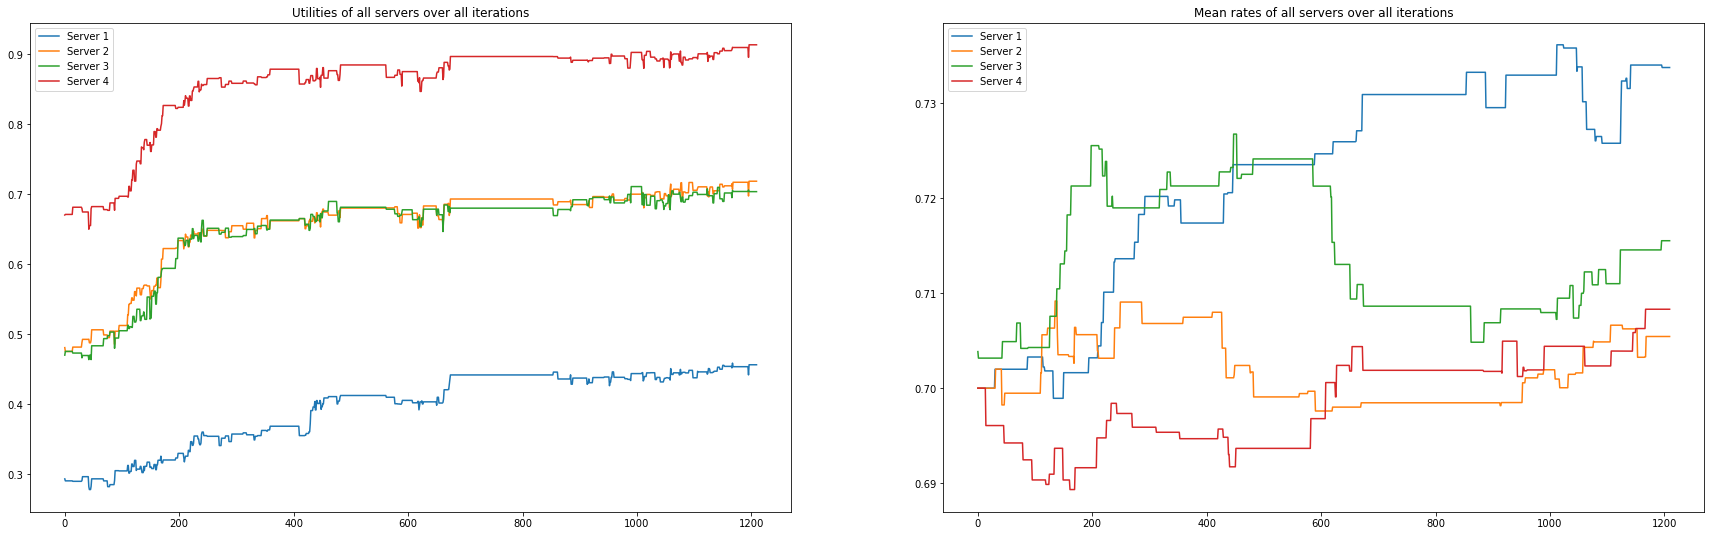

In [456]:
# plt.figure(figsize=(14, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in all_utilities])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, parameters["num_of_servers"] + 1):
    current_server_rate = [np.mean(list(rates[srv].values())) for rates in all_rates]
    ax2.plot(current_server_rate)
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")
plt.show()

In [458]:
all_diff_rates = []
for srv_id in range(1, num_of_servers + 1):
    diff_rates = np.zeros((buffer_capacity + 1, system_capacity + 1))
    for (u, v) in initial_rates[srv_id].keys():
        diff_rates[u, v] = rates[srv_id][(u,v)] - initial_rates[srv_id][(u,v)]
    all_diff_rates.append(diff_rates)

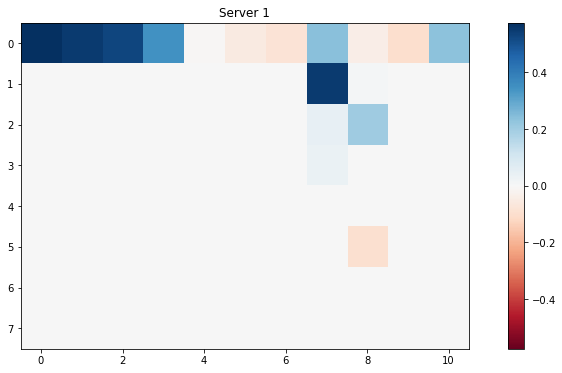

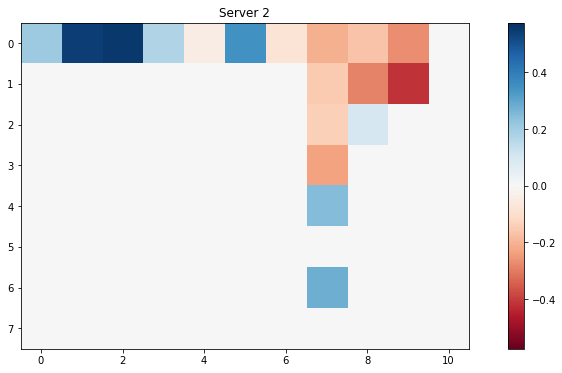

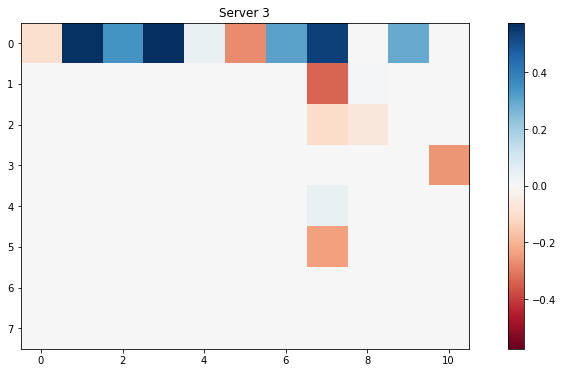

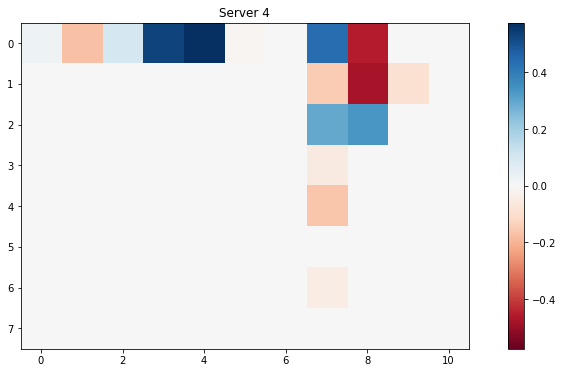

In [459]:
for srv_id in range(1, num_of_servers + 1):
    plt.figure(figsize=(14, 6))
    plt.title(f"Server {srv_id}")
    plt.imshow(all_diff_rates[srv_id - 1], cmap="RdBu")
    plt.colorbar()
    abs_max = np.max(np.abs(all_diff_rates[0]))
    plt.clim(-abs_max,abs_max)

## e = 0.5
$$
    U_k^3 = e (\text{mean service time})_k + (1 - e) (\text{idle proportion})_k
$$

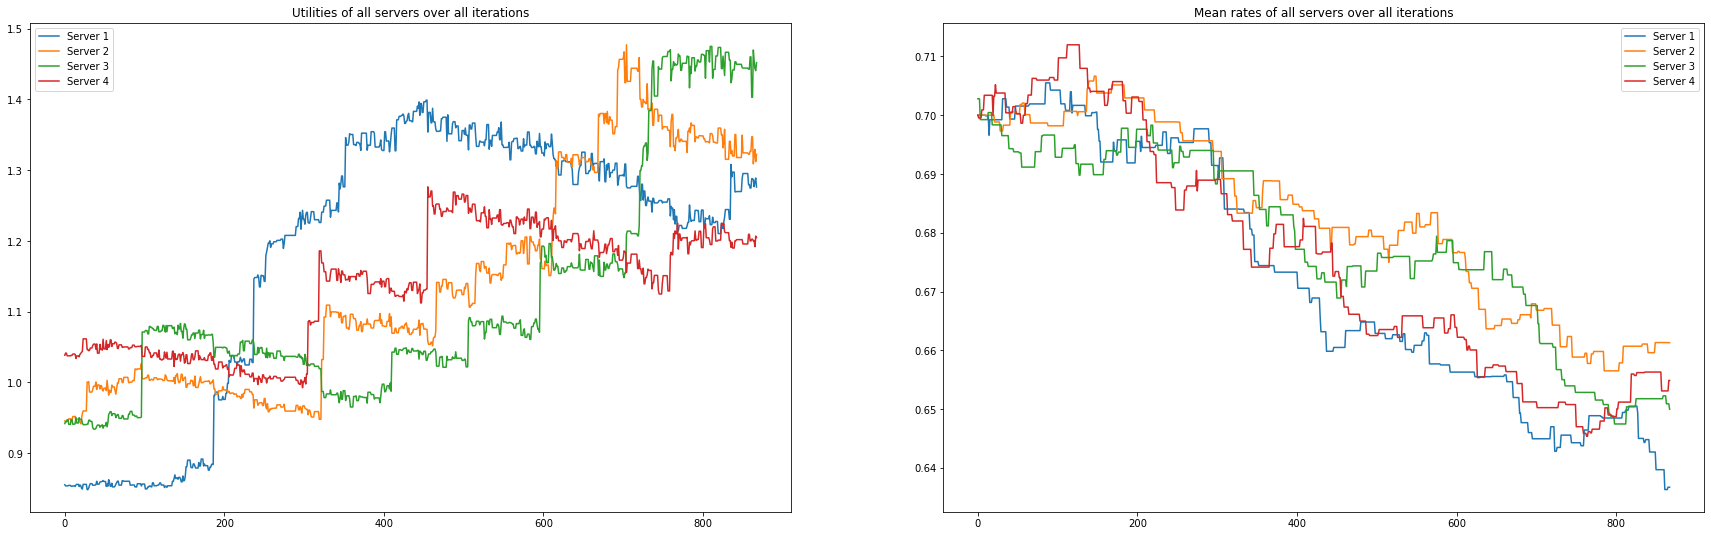

In [442]:
# plt.figure(figsize=(14, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in all_utilities])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, parameters["num_of_servers"] + 1):
    current_server_rate = [np.mean(list(rates[srv].values())) for rates in all_rates]
    ax2.plot(current_server_rate)
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")
plt.show()

In [443]:
all_diff_rates = []
for srv_id in range(1, num_of_servers + 1):
    diff_rates = np.zeros((buffer_capacity + 1, system_capacity + 1))
    for (u, v) in initial_rates[srv_id].keys():
        diff_rates[u, v] = rates[srv_id][(u,v)] - initial_rates[srv_id][(u,v)]
    all_diff_rates.append(diff_rates)

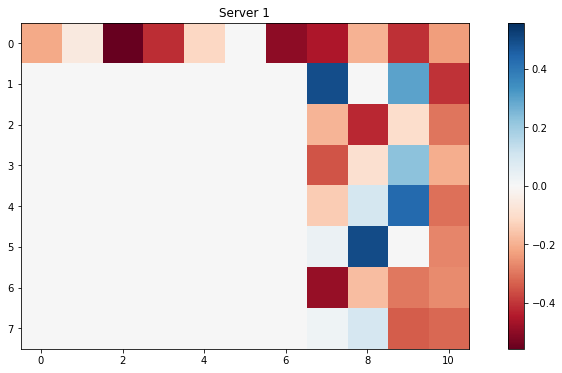

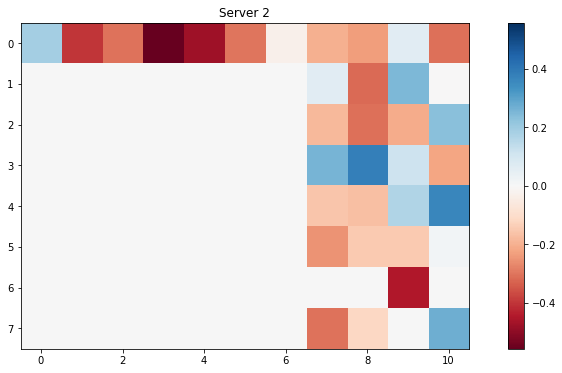

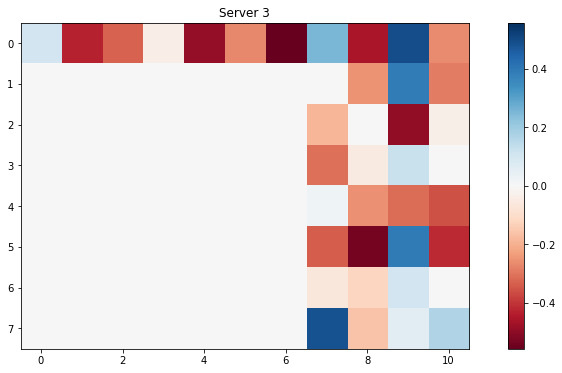

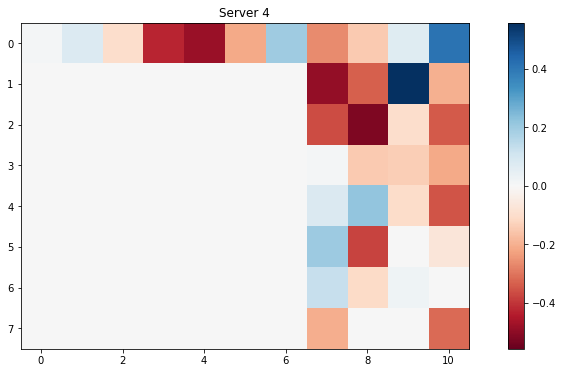

In [444]:
for srv_id in range(1, num_of_servers + 1):
    plt.figure(figsize=(14, 6))
    plt.title(f"Server {srv_id}")
    plt.imshow(all_diff_rates[srv_id - 1], cmap="RdBu")
    plt.colorbar()
    abs_max = np.max(np.abs(all_diff_rates[0]))
    plt.clim(-abs_max,abs_max)

## e = 1
$$
    U_k^3 = e (\text{mean service time})_k + (1 - e) (\text{idle proportion})_k
$$

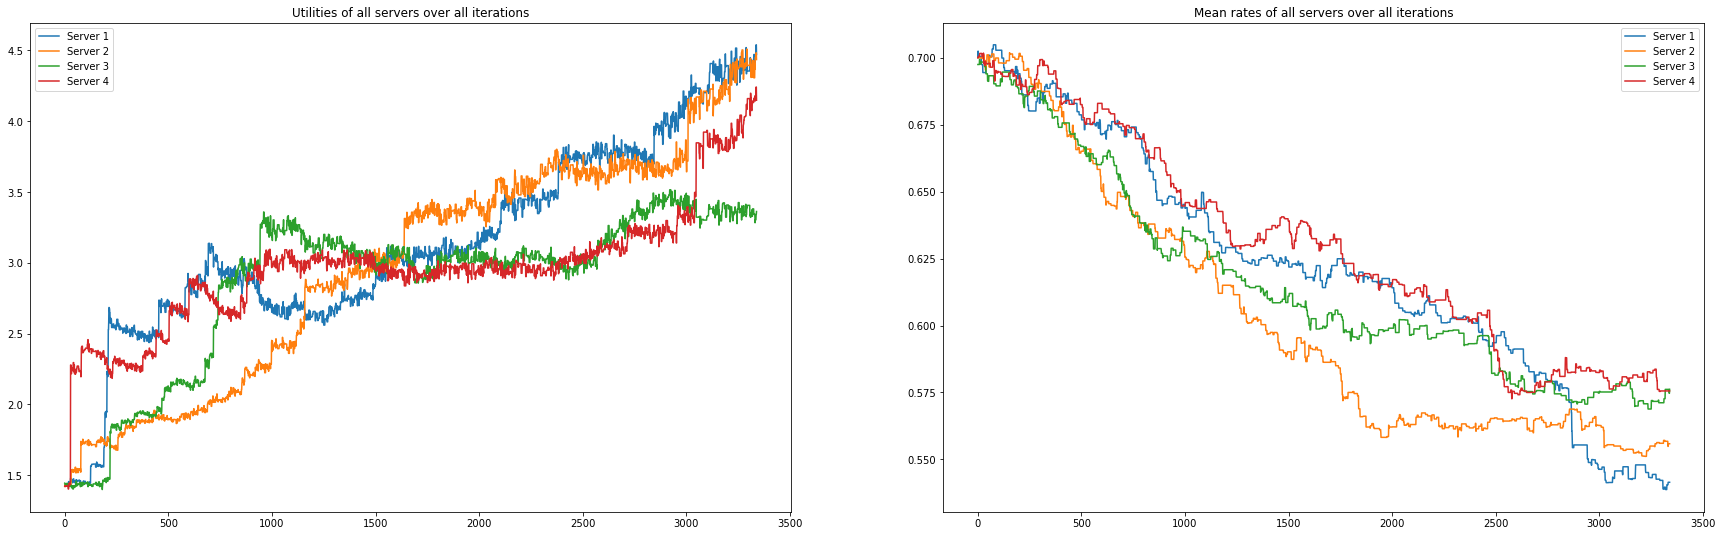

In [427]:
# plt.figure(figsize=(14, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in all_utilities])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, parameters["num_of_servers"] + 1):
    current_server_rate = [np.mean(list(rates[srv].values())) for rates in all_rates]
    ax2.plot(current_server_rate)
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")
plt.show()

In [428]:
all_diff_rates = []
for srv_id in range(1, num_of_servers + 1):
    diff_rates = np.zeros((buffer_capacity + 1, system_capacity + 1))
    for (u, v) in initial_rates[srv_id].keys():
        diff_rates[u, v] = rates[srv_id][(u,v)] - initial_rates[srv_id][(u,v)]
    all_diff_rates.append(diff_rates)

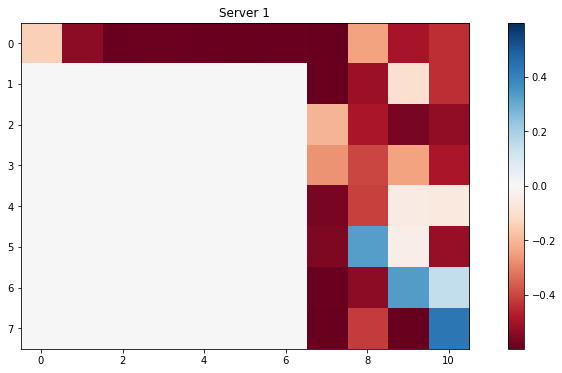

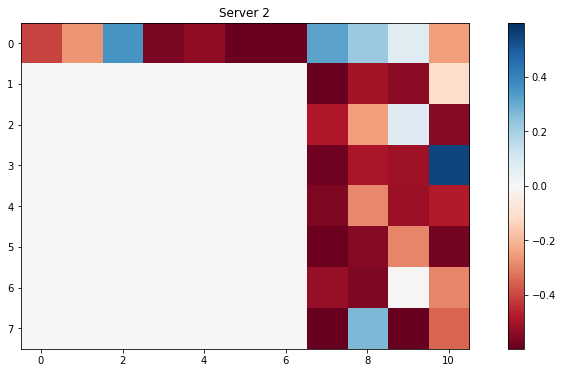

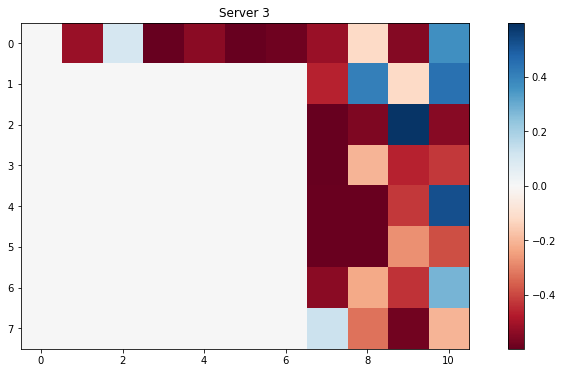

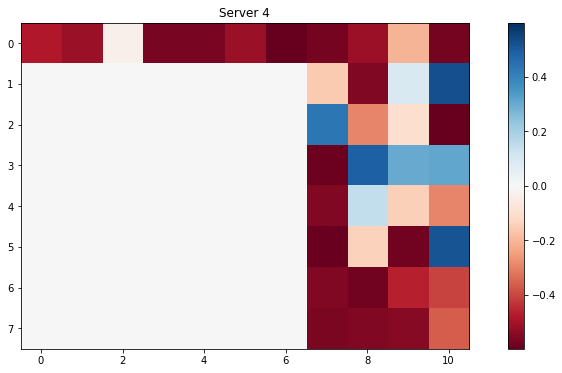

In [429]:
for srv_id in range(1, num_of_servers + 1):
    plt.figure(figsize=(14, 6))
    plt.title(f"Server {srv_id}")
    plt.imshow(all_diff_rates[srv_id - 1], cmap="RdBu")
    plt.colorbar()
    abs_max = np.max(np.abs(all_diff_rates[0]))
    plt.clim(-abs_max,abs_max)